# Investigating well position effect: Scenario 4
**Author:** Jessica Ewald <br>

Here we train on three plates and test on the fourth, all from the same batch. 

These results are for only one example: train on "2023-12-15_B4A3R1_P1T2", "2023-12-18_B4A3R1_P1T3", "2023-12-15_B4A3R1_P1T1", test on "2023-12-18_B4A3R1_P1T4". These plates are from batch 4. This scenario is most similar to our real analysis strategy. 

In [1]:
# Imports
import pathlib
import polars as pl
import pandas as pd
import numpy as np
from scipy import stats
import os
import seaborn as sns
import matplotlib.pyplot as plt

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import warnings
warnings.filterwarnings("ignore")

DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


In [3]:
result_dir = pathlib.Path(f'/dgx1nas1/storage/data/jess/varchamp/sc_data/classification_results/Rep_Ctrls_scen4')
batch = 'Rep_Ctrls_scen4'
feature_sets = ['non_protein', 'protein', 'brightfield']

In [4]:
# Read in all F1 score and plot
comparisons = ['REF_control_f1score', 'VAR_control_f1score', 'NULL_control_f1score', 'f1score']
comp_dict = {'REF_control_f1score': 'REF_REF',
             'VAR_control_f1score': 'VAR_VAR',
             'NULL_control_f1score': 'NULL',
             'f1score': 'REF_VAR'}

f1_score = pl.DataFrame()
for fs in feature_sets:
    for comp in comparisons:
        
        df = pl.read_csv(f'{result_dir}/Rep_Ctrls_scen3_{fs}_{comp}_normalized_feature_selected.csv')
        
        if "Reference_Well" in df.columns:
            df = df.rename({"Reference_Well": "Well_One", "Variant_Well": "Well_Two"})
            
        df = df.melt(id_vars = ['Well_One', 'Well_Two']).with_columns(pl.lit(fs).alias("Feature_Set"),
                                                                      pl.lit(comp_dict[comp]).alias('Comparison'),
                                                                      pl.lit(batch).alias('Batch'))
        f1_score = pl.concat([f1_score, df], how = "vertical")

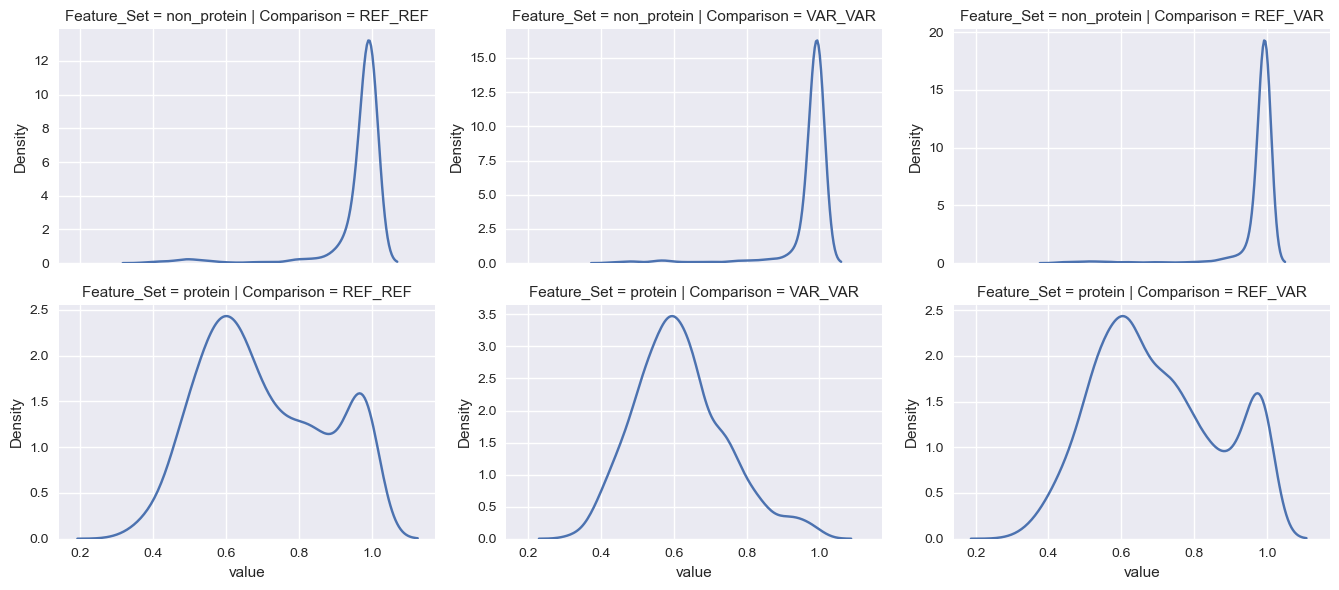

In [5]:
# plot F1 scores, faceted by Feature Set and Comparison

plt.style.use('seaborn')

g = sns.FacetGrid(f1_score.filter(pl.col("variable") == "F1_Score").to_pandas(), row='Feature_Set', col='Comparison', aspect=1.5, sharey=False)
g.map(sns.kdeplot, 'value')

plt.show()

In [6]:
# Read in all variable feature importance scores

comparisons = ['REF_control_feat_importance', 'VAR_control_feat_importance', 'NULL_feat_importance', 'feat_importance']
comp_dict = {'REF_control_feat_importance': 'REF_REF',
             'VAR_control_feat_importance': 'VAR_VAR',
             'NULL_feat_importance': 'NULL',
             'feat_importance': 'REF_VAR'}

feat_imp = pl.DataFrame()
for fs in feature_sets:
    for comp in comparisons:
        
        df = pl.read_csv(f'{result_dir}/Rep_Ctrls_scen3_{fs}_{comp}_normalized_feature_selected.csv')
        
        if "Reference_Well" in df.columns:
            df = df.rename({"Reference_Well": "Well_One", "Variant_Well": "Well_Two"})
            
        df = df.melt(id_vars = ['Well_One', 'Well_Two']).with_columns(pl.lit(fs).alias("Feature_Set"),
                                                                      pl.lit(comp_dict[comp]).alias('Comparison'),
                                                                      pl.lit(batch).alias('Batch'))
        feat_imp = pl.concat([feat_imp, df], how = "vertical")

In [7]:
# Add unique identifier
feat_imp = feat_imp.with_columns(pl.concat_str([pl.col("Well_One"), pl.col("Well_Two"), pl.col("Feature_Set"), pl.col("Comparison")], separator="_").alias("ClassifierID"))

# Add rank of feature within each classifier
feat_imp = feat_imp.with_columns(pl.col("value").rank(descending=True).over("ClassifierID").alias("FIP_rank"))

In [8]:
# summarize ranks

imp_summary = feat_imp.group_by(["variable", "Feature_Set", "Comparison"]).agg(pl.col("FIP_rank").mean().alias("mean_VIP"))
prot_summary = imp_summary.filter(pl.col("Feature_Set") == "protein").pivot(index="variable", columns="Comparison", values="mean_VIP")
nonprot_summary = imp_summary.filter(pl.col("Feature_Set") == "non_protein").pivot(index="variable", columns="Comparison", values="mean_VIP")
brightfield_summary = imp_summary.filter(pl.col("Feature_Set") == "brightfield").pivot(index="variable", columns="Comparison", values="mean_VIP")

In [ ]:
sns.pairplot(prot_summary.to_pandas())

In [ ]:
sns.pairplot(nonprot_summary.to_pandas())

In [ ]:
sns.pairplot(brightfield_summary.to_pandas())

Here, finally, we see a wider range of F1 scores but unfortunately the distributions are super consistent across different comparison types (REF-REF, VAR-VAR, REF-VAR). Next, analyze these scores to see if there is any spatial pattern across the plate.

In [16]:

f1_score = f1_score.filter(pl.col("variable") == "F1_Score")

# Convert well name into row and column coordinates
f1_score =f1_score.with_columns(pl.col("Well_One").str.slice(0,1).alias("Well_One_Letter"),
                                pl.col("Well_One").str.slice(1).cast(pl.Int64).alias("Well_One_Col"),
                                pl.col("Well_Two").str.slice(0,1).alias("Well_Two_Letter"),
                                pl.col("Well_Two").str.slice(1).cast(pl.Int64).alias("Well_Two_Col"))

letter_dict = {"A":1, "B":2, "C":3, "D":4, "E":5, "F":6, "G":7, "H":8, "I":9, "J":10, "K":11, "L":12, "M":13, "N":14, "O":15, "P":16}

f1_score = f1_score.with_columns(pl.Series(name="Well_One_Row", values=[letter_dict[val] for val in f1_score.select(pl.col("Well_One_Letter")).to_series()]),
                                 pl.Series(name="Well_Two_Row", values=[letter_dict[val] for val in f1_score.select(pl.col("Well_Two_Letter")).to_series()]))

In [17]:
# Compute physical distance between pairs of wells
import math

phys_dist = []
for row in f1_score.rows(named=True):
    phys_dist.append(math.dist([row['Well_One_Row'], row['Well_One_Col']], [row['Well_Two_Row'], row['Well_Two_Col']]))
 

In [18]:
dists = f1_score.with_columns(pl.Series(name="Phys_dist", values=phys_dist),
                              pl.concat_str([pl.col("Well_One"), pl.col("Well_Two")], separator="-").alias("Well_Pair"))

In [20]:
# Compute correlation between cosine similarity and physical distance
dist_cor = dists.group_by(["Comparison", "Feature_Set"]).agg(pl.corr("value", "Phys_dist").alias("Cor_F1_Dist"))
dist_cor.head

<bound method DataFrame.head of shape: (6, 3)
┌────────────┬─────────────┬─────────────┐
│ Comparison ┆ Feature_Set ┆ Cor_F1_Dist │
│ ---        ┆ ---         ┆ ---         │
│ str        ┆ str         ┆ f64         │
╞════════════╪═════════════╪═════════════╡
│ REF_VAR    ┆ non_protein ┆ 0.013973    │
│ VAR_VAR    ┆ non_protein ┆ -0.055642   │
│ REF_REF    ┆ non_protein ┆ 0.02168     │
│ VAR_VAR    ┆ protein     ┆ 0.28262     │
│ REF_REF    ┆ protein     ┆ 0.197284    │
│ REF_VAR    ┆ protein     ┆ 0.241407    │
└────────────┴─────────────┴─────────────┘>